In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/content/drive/My Drive"


Crimes_2001_to_Present.csv


In [4]:
data_path = "/content/drive/My Drive/content/drive/My Drive/Crimes_2001_to_Present.csv"


In [5]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType

schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", IntegerType(), True),
    StructField("Community Area", StringType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", FloatType(), True),
    StructField("Y Coordinate", FloatType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", FloatType(), True),
    StructField("Longitude", FloatType(), True),
    StructField("Location", StringType(), True)
])


In [7]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [8]:
!pip install -q pyspark


In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ChicagoCrimeAnalysis") \
    .getOrCreate()


In [10]:
crime_df = spark.read.csv(data_path, schema=schema, header=True)


In [11]:
crime_df.show(5)


+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11037294|   JA371270|03/18/2015 12:00:...|   0000X W WACKER DR|1153|DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|                BANK| false|   false|0111|     001|  42|            32|      11| 

In [12]:
## Removing null values
crime_df = crime_df.na.drop()


In [13]:
## Changing Date column data type to Timestamp
from pyspark.sql.functions import to_timestamp

crime_df = crime_df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))


In [14]:
## Filtering for last ten years
from pyspark.sql.functions import year

crime_df = crime_df.filter(year("Date") >= 2014)


In [15]:
## Removing specific crime types
excluded_types = ["NON-CRIMINAL (SUBJECT SPECIFIED)", "OTHER OFFENSE", "STALKING", "NON - CRIMINAL", "ARSON"]
crime_df = crime_df.filter(~crime_df["Primary Type"].isin(excluded_types))


In [16]:
## Merging similar crime types
from pyspark.sql.functions import when

crime_df = crime_df.withColumn(
    "Primary Type",
    when(crime_df["Primary Type"].isin("SEX OFFENSE", "PROSTITUTION"), "SEXUAL CRIME").otherwise(crime_df["Primary Type"])
)


In [17]:
## year wise trend for last ten years
year_trend = crime_df.groupBy(year("Date").alias("Year")).count().orderBy("Year")
year_trend.show()


+----+------+
|Year| count|
+----+------+
|2014|256126|
|2015|239895|
|2016|248598|
|2017|246569|
|2018|245390|
|2019|240854|
|2020|193870|
|2021|187552|
|2022|219017|
|2023|243895|
|2024|194142|
+----+------+



In [18]:
# hour with the highest crime rate
from pyspark.sql.functions import hour

peak_hour = crime_df.groupBy(hour("Date").alias("Hour")).count().orderBy("count", ascending=False)
peak_hour.show(1)  # Shows the hour with the highest crime rate


+----+------+
|Hour| count|
+----+------+
|  12|145011|
+----+------+
only showing top 1 row



In [19]:
## top 10 most frequent crimes
top_crimes = crime_df.groupBy("Primary Type").count().orderBy("count", ascending=False).limit(10)
top_crimes.show()


+-------------------+------+
|       Primary Type| count|
+-------------------+------+
|              THEFT|607595|
|            BATTERY|500988|
|    CRIMINAL DAMAGE|300406|
|            ASSAULT|213884|
| DECEPTIVE PRACTICE|170133|
|MOTOR VEHICLE THEFT|150371|
|          NARCOTICS|128333|
|           BURGLARY|113001|
|            ROBBERY|104077|
|  WEAPONS VIOLATION| 67806|
+-------------------+------+



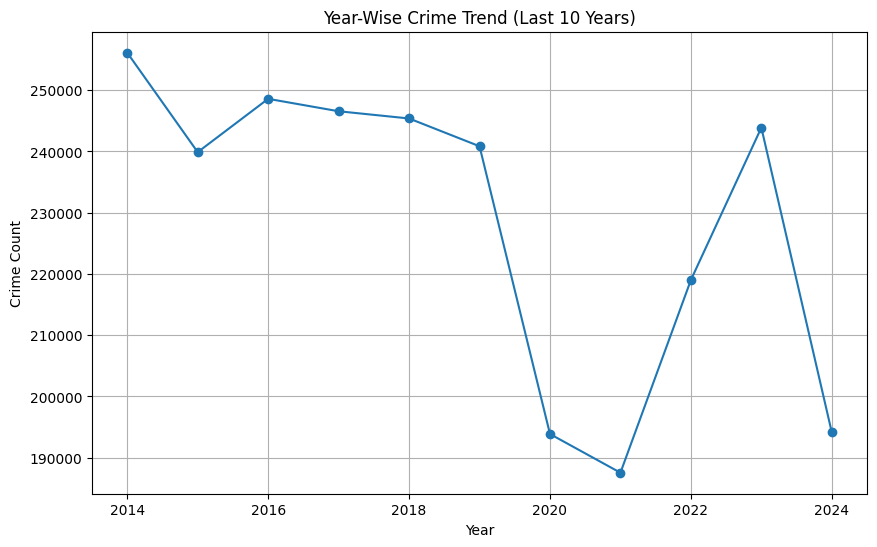

In [20]:
## year-wise trend visualization

import matplotlib.pyplot as plt

year_trend_pd = year_trend.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(year_trend_pd["Year"], year_trend_pd["count"], marker="o")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.title("Year-Wise Crime Trend (Last 10 Years)")
plt.grid(True)
plt.show()


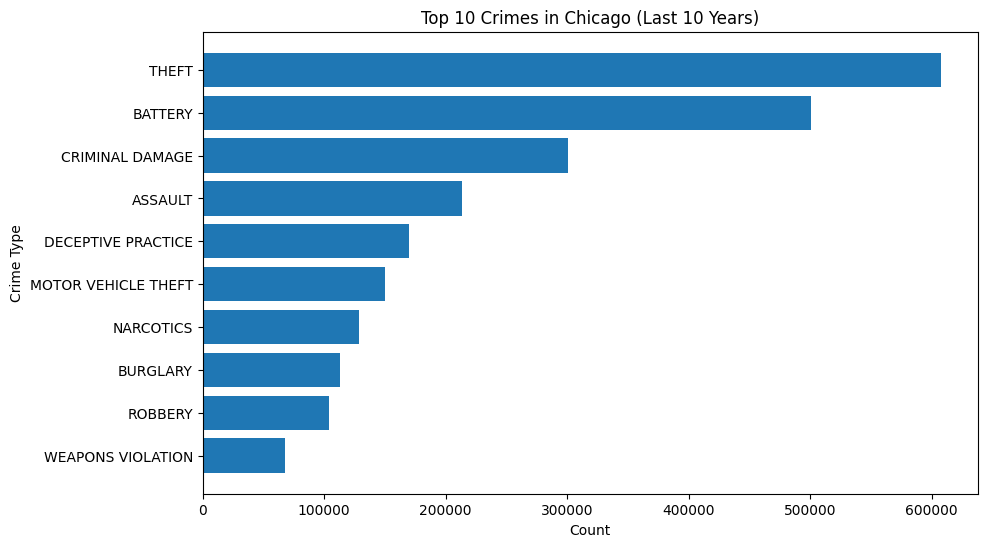

In [21]:
## top 10 crimes

top_crimes_pd = top_crimes.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_crimes_pd["Primary Type"], top_crimes_pd["count"])
plt.xlabel("Count")
plt.ylabel("Crime Type")
plt.title("Top 10 Crimes in Chicago (Last 10 Years)")
plt.gca().invert_yaxis()
plt.show()
